<div style="text-align: right"> Tommy Evans-Barton </div>
<div style="text-align: right"> WR Year 2 Jumps </div>

# Analysis and Modeling Notebook

The purpose of this notebook is to develop the model used to predict second year production for receivers based on their statistics in their first year. This notebook will also serve as a preliminary 'final notebook' before the final presentation of this project's findings.

In [160]:
import os
import sys
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
import scipy.stats
from scipy.optimize import minimize

In [161]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
TOP_PATH = os.environ['PWD']

## Reading in Data

In [163]:
df = pd.read_csv(TOP_PATH + '/data/final/FINAL_DATA.csv')
df

,Rnd,Pick,Team,Player,First Year,Age Draft,G,GS,Tgt,WR Tgt Share,...,Projected Rec Share,Projected Rec,Projected Yds Share,Projected Yds,Projected TD Share,Projected TD,Rec Pts First Season,Rec Pts/G First Season,Rec Pts Second Season,Rec Pts/G Second Season
0,1,3,CLE,B.Edwards,2005,22,10.0,7.0,59.0,0.226923,...,0.425007,61.201005,0.498598,981.739542,0.222222,2.0,69.2,6.920000,124.4,7.775000
1,1,7,MIN,T.Williamson,2005,22,14.0,3.0,52.0,0.180556,...,0.484076,76.000000,0.483380,1047.000000,0.307692,4.0,49.2,3.514286,45.5,3.250000
2,1,10,DET,M.Williams,2005,21,14.0,4.0,57.0,0.256757,...,0.381579,43.500000,0.257708,374.707921,-0.444444,-4.0,41.0,2.928571,15.9,1.987500
3,1,21,JAX,M.Jones,2005,22,16.0,1.0,69.0,0.206587,...,0.582418,106.000000,0.563735,1455.000000,0.611111,11.0,73.2,4.575000,88.3,6.307143
4,1,22,BAL,M.Clayton,2005,23,14.0,10.0,87.0,0.388393,...,0.338462,44.000000,0.305052,471.000000,0.400000,2.0,59.1,4.221429,123.9,7.743750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,2,57,PHI,J.Arcega-Whiteside,2019,22,16.0,5.0,22.0,0.126437,...,0.485149,49.000000,0.450466,532.000000,0.400000,4.0,22.9,1.431250,NaN,NaN
127,2,64,SEA,D.Metcalf,2019,21,16.0,15.0,100.0,0.375940,...,0.424419,73.000000,0.457451,1145.000000,0.444444,8.0,132.0,8.250000,NaN,NaN
128,3,66,PIT,D.Johnson,2019,23,16.0,12.0,92.0,0.380165,...,0.406897,59.000000,0.345704,680.000000,0.454545,5.0,98.0,6.125000,NaN,NaN
129,3,76,WAS,T.McLaurin,2019,23,14.0,14.0,93.0,0.505435,...,0.508772,58.000000,0.620108,919.000000,0.875000,7.0,133.9,9.564286,NaN,NaN


In [164]:
df_model = df[df['First Year'] < 2019].reset_index(drop = True)
df_prediction = df[df['First Year'] == 2019].reset_index(drop = True)

In [165]:
df_model

,Rnd,Pick,Team,Player,First Year,Age Draft,G,GS,Tgt,WR Tgt Share,...,Projected Rec Share,Projected Rec,Projected Yds Share,Projected Yds,Projected TD Share,Projected TD,Rec Pts First Season,Rec Pts/G First Season,Rec Pts Second Season,Rec Pts/G Second Season
0,1,3,CLE,B.Edwards,2005,22,10.0,7.0,59.0,0.226923,...,0.425007,61.201005,0.498598,981.739542,0.222222,2.000000,69.2,6.920000,124.4,7.775000
1,1,7,MIN,T.Williamson,2005,22,14.0,3.0,52.0,0.180556,...,0.484076,76.000000,0.483380,1047.000000,0.307692,4.000000,49.2,3.514286,45.5,3.250000
2,1,10,DET,M.Williams,2005,21,14.0,4.0,57.0,0.256757,...,0.381579,43.500000,0.257708,374.707921,-0.444444,-4.000000,41.0,2.928571,15.9,1.987500
3,1,21,JAX,M.Jones,2005,22,16.0,1.0,69.0,0.206587,...,0.582418,106.000000,0.563735,1455.000000,0.611111,11.000000,73.2,4.575000,88.3,6.307143
4,1,22,BAL,M.Clayton,2005,23,14.0,10.0,87.0,0.388393,...,0.338462,44.000000,0.305052,471.000000,0.400000,2.000000,59.1,4.221429,123.9,7.743750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2,51,CHI,A.Miller,2018,23,15.0,4.0,54.0,0.192171,...,0.544404,98.537037,0.495570,1036.732673,0.533333,8.000000,84.3,5.620000,77.6,4.850000
117,2,60,PIT,J.Washington,2018,22,14.0,6.0,38.0,0.094763,...,0.550607,136.000000,0.532306,1623.000000,0.695652,16.000000,27.7,1.978571,91.5,6.100000
118,2,61,JAX,D.Chark,2018,21,11.0,0.0,32.0,0.109589,...,0.208546,34.618557,0.291061,596.675743,0.148148,1.333333,17.4,1.581818,148.8,9.920000
119,3,81,DAL,M.Gallup,2018,22,16.0,8.0,68.0,0.311927,...,0.787760,107.923077,0.795709,1346.339575,0.677778,6.100000,62.7,3.918750,146.7,10.478571


In [166]:
df_prediction

,Rnd,Pick,Team,Player,First Year,Age Draft,G,GS,Tgt,WR Tgt Share,...,Projected Rec Share,Projected Rec,Projected Yds Share,Projected Yds,Projected TD Share,Projected TD,Rec Pts First Season,Rec Pts/G First Season,Rec Pts Second Season,Rec Pts/G Second Season
0,1,25,BAL,M.Brown,2019,22,14.0,11.0,71.0,0.396648,...,0.587719,67.000000,0.605096,855.000000,0.529412,9.000000,100.4,7.171429,NaN,NaN
1,1,32,NWE,N.Harry,2019,21,7.0,5.0,24.0,0.129730,...,0.089364,10.366197,0.075781,96.848335,0.222222,2.000000,22.5,3.214286,NaN,NaN
2,2,36,SFO,D.Samuel,2019,23,15.0,11.0,81.0,0.476471,...,0.458549,50.440367,0.498320,725.054975,0.217172,2.388889,98.2,6.546667,NaN,NaN
3,2,51,TEN,A.Brown,2019,22,16.0,11.0,84.0,0.350000,...,0.492268,78.270642,0.587432,1393.388276,0.750000,12.000000,153.1,9.568750,NaN,NaN
4,2,56,KAN,M.Hardman,2019,21,16.0,5.0,41.0,0.149091,...,0.154762,26.000000,0.213492,538.000000,0.300000,6.000000,89.8,5.612500,NaN,NaN
5,2,57,PHI,J.Arcega-Whiteside,2019,22,16.0,5.0,22.0,0.126437,...,0.485149,49.000000,0.450466,532.000000,0.400000,4.000000,22.9,1.431250,NaN,NaN
6,2,64,SEA,D.Metcalf,2019,21,16.0,15.0,100.0,0.375940,...,0.424419,73.000000,0.457451,1145.000000,0.444444,8.000000,132.0,8.250000,NaN,NaN
7,3,66,PIT,D.Johnson,2019,23,16.0,12.0,92.0,0.380165,...,0.406897,59.000000,0.345704,680.000000,0.454545,5.000000,98.0,6.125000,NaN,NaN
8,3,76,WAS,T.McLaurin,2019,23,14.0,14.0,93.0,0.505435,...,0.508772,58.000000,0.620108,919.000000,0.875000,7.000000,133.9,9.564286,NaN,NaN
9,3,93,BAL,M.Boykin,2019,22,16.0,11.0,22.0,0.122905,...,0.298246,34.000000,0.331918,469.000000,0.294118,5.000000,37.8,2.362500,NaN,NaN


In [167]:
X_temp, X_test, y_temp, y_test = train_test_split(df_model.drop(['Rec Pts Second Season', 'Rec Pts/G Second Season'], axis = 1), df_model['Rec Pts/G Second Season'], test_size = 0.2, random_state = 1)

In [168]:
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size = 0.2, random_state = 1)

In [169]:
X_train = X_train.reset_index(drop = True)
X_valid = X_valid.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_valid = y_valid.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [170]:
def median_abs_error(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.median(abs(y_true - y_pred))

In [648]:
cat_feat = ['Rnd', 'Age Draft']

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(categories = 'auto'))     # categorical columns become input to OneHot
])

reg_num_feat = ['Pick', 'First Year', 'Age Draft', 'G', 'GS',
        'Tgt', 'Catch Rate', 'Y/R', 'TD', 'WR TD Share', 'Lng', 'Y/Tgt', 'Y/G', 
        'Projected Tgt Share', 'Projected Tgt', 'Projected Rec Share', 'Projected Rec', 'Projected Yds Share',
        'Projected Yds', 'Projected TD Share', 'Projected TD']
sqrt_num_feat = ['WR Tgt Share', 'Rec', 'WR Rec Share', 'Yds', 'WR Yds Share', '1D', 
                 'R/G', 'EYds', 'Rec Pts First Season', 'Rec Pts/G First Season']
adv_num_feat = ['DYAR', 'YAR', 'DVOA', 'VOA', 'DPI Pens', 'DPI Yds']
num_feat = reg_num_feat + sqrt_num_feat + adv_num_feat

sqrt_transformer = Pipeline(steps = [
    ('sqrt', FunctionTransformer(lambda x : x**.5))
])

num_transformer = Pipeline(steps=[
    ('none', FunctionTransformer(lambda x : x))
])

small_selection = ['Tgt', 'TD', 'Y/G', 'Lng', 'Projected Yds']
small_sqrt = ['WR Tgt Share', 'Rec', 'R/G', '1D', 'EYds', 'Rec Pts/G First Season', 'Rec Pts First Season']

preproc1 = ColumnTransformer(transformers=[('sqrt', sqrt_transformer, small_sqrt), ('none', num_transformer, small_selection), ('cat', cat_transformer, cat_feat)])

pl = Pipeline(steps=[('preprocessor', preproc1), ('regressor', LinearRegression(normalize = True))])

In [649]:
pl.fit(X_train[small_selection + small_sqrt + cat_feat], y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('sqrt',
                                                  Pipeline(memory=None,
                                                           steps=[('sqrt',
                                                                   FunctionTransformer(accept_sparse=False,
                                                                                       check_inverse=True,
                                                                                       func=<function <lambda> at 0x7fb3ce46a290>,
                                                                                       inv_kw_args=None,
                                                                                       inverse_func=None,

In [650]:
pd.DataFrame(zip(small_selection + small_sqrt + ['Rnd1', 'Rnd2', 'Rnd3'] + list(set(df_model['Age Draft'])), pl.named_steps['regressor'].coef_)) 

,0,1
0,Tgt,-8.615163
1,TD,-2.765367
2,Y/G,4.095227
3,Lng,0.354312
4,Projected Yds,0.091472
5,WR Tgt Share,-3.856678
6,Rec,2.454372
7,R/G,0.017333
8,1D,-0.606461
9,EYds,0.123592


In [651]:
valid_pred = pl.predict(X_valid[small_selection + small_sqrt + ['Rnd', 'Age Draft']])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


In [652]:
train_pred = pl.predict(X_train[small_selection + small_sqrt + ['Rnd', 'Age Draft']])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


In [653]:
valid_pred

array([ 5.99660685,  4.36931543,  1.62898701,  7.64502248,  1.0797574 ,
       11.62545345,  5.5087328 ,  6.84325115, 13.01241978,  6.29276788,
        6.70712183,  5.68238911,  3.81956018,  8.6660847 , 10.19639071,
       10.1059211 ,  5.16795444,  7.00164644,  5.4333268 ,  8.85786774])

In [654]:
temp = X_valid.copy()
temp['Actual'] = y_valid
temp['Prediction'] = valid_pred

In [655]:
temp_train = X_train.copy()
temp_train['Actual'] = y_train
temp_train['Prediction'] = train_pred

In [656]:
#Validation Error
np.sqrt(np.mean((y_valid - valid_pred) ** 2))

1.9588654910794863

In [657]:
#Training Error
np.sqrt(np.mean((y_train - train_pred) ** 2))

1.9895895211820185

In [658]:
temp['Absolute Error'] = np.abs(valid_pred - y_valid)

In [659]:
temp['Error'] = (valid_pred - y_valid)

In [660]:
temp.sort_values('Absolute Error')

,Rnd,Pick,Team,Player,First Year,Age Draft,G,GS,Tgt,WR Tgt Share,...,Projected Yds Share,Projected Yds,Projected TD Share,Projected TD,Rec Pts First Season,Rec Pts/G First Season,Actual,Prediction,Absolute Error,Error
7,3,74,DAL,T.Williams,2013,23,16.0,8.0,74.0,0.211429,...,0.368283,980.000000,0.227273,5.000000,103.6,6.475000,6.881250,6.843251,0.037999,-0.037999
5,2,49,PHI,D.Jackson,2008,21,16.0,15.0,120.0,0.331492,...,0.610772,1599.000000,0.545455,6.000000,103.2,6.450000,11.306667,11.625453,0.318787,0.318787
15,1,20,NOR,B.Cooks,2014,20,10.0,7.0,69.0,0.244681,...,0.594479,1539.105712,0.402597,4.428571,73.0,7.300000,10.487500,10.105921,0.381579,-0.381579
8,1,4,CIN,A.Green,2011,23,15.0,15.0,115.0,0.357143,...,0.888654,2099.000000,1.000000,14.000000,147.7,9.846667,12.562500,13.012420,0.449920,0.449920
19,1,24,CAR,D.Moore,2018,21,16.0,10.0,82.0,0.257862,...,0.800485,1982.000000,0.642857,9.000000,90.8,5.675000,9.433333,8.857868,0.575466,-0.575466
6,2,51,CHI,A.Miller,2018,23,15.0,4.0,54.0,0.192171,...,0.495570,1036.732673,0.533333,8.000000,84.3,5.620000,4.850000,5.508733,0.658733,0.658733
17,2,44,DET,T.Young,2011,22,16.0,9.0,86.0,0.237569,...,0.191993,598.249408,0.240000,6.000000,96.7,6.043750,6.230000,7.001646,0.771646,0.771646
10,1,20,TEN,K.Wright,2012,22,15.0,5.0,104.0,0.317073,...,0.273961,626.000000,0.333333,4.000000,86.6,5.773333,7.493750,6.707122,0.786628,-0.786628
4,3,85,HOU,B.Miller,2016,23,10.0,6.0,28.0,0.103321,...,-0.018937,-31.965517,0.055901,0.391304,15.9,1.590000,2.018182,1.079757,0.938424,-0.938424
14,2,42,PHI,J.Matthews,2014,22,16.0,10.0,103.0,0.299419,...,0.576327,1601.036502,0.607143,12.750000,135.2,8.450000,9.231250,10.196391,0.965141,0.965141


**CURRENT BEST FEATURES LIST**:
    
    ['Tgt', 'Projected Tgt Share', 'Yds', 'TD', 'Yds', Rec', '1D', 'Y/G', 'EYds', 'Rec Pts First Season', 'Rec Pts/G First Season', 'Rnd', 'GS']
    
    RMSE: 1.9745377338693273

Thoughts:

- One hot encode round
- use pick straight up
- use year straight up (?)
- use age draft straight up
- use each stat straight up
- MIGHT NEED MORE DATA

Possible more features:

- Target share
- Yard share
- Number of receivers ahead of them for their team
- Number of available targets: Targets that left team - Targets that came into team ?
- Receivers drafted in first 2 days by team


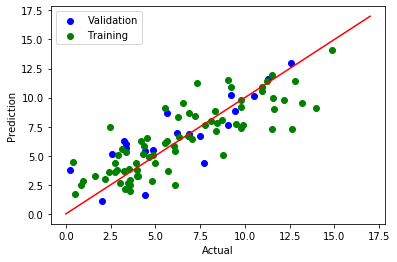

In [661]:
plt.scatter(temp['Actual'] , temp['Prediction'], c='b', label = 'Validation')
plt.scatter(temp_train['Actual'], temp_train['Prediction'], c = 'g', label = 'Training')
plt.plot(range(18), range(18), color = 'r')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.legend(loc='upper left')
plt.show()
#Save this FIGURE and then 

In [662]:
pl.score(X_valid[small_selection + small_sqrt + cat_feat], y_valid)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


0.6462688700766398